### CAPM

- In this exercise we will fit CAPM with real financial data(stock prices) and test whether the predictions of CAPM are true.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()
import pandas_datareader.data as web
import statsmodels.api as sm
from statsmodels.formula.api import ols 

### Empirical test of CAPM

- We will conduct a simple test on whether the predictions of CAPM hold.
    - Asset return is a function of how much risk it is exposed to.
    - Thus, asset returns should be increasing in betas.
- It is done by the following steps.
    - Setting up the sample data
    - Estimating betas
    - Estimating the SML

In [2]:
df = pd.read_excel('beta_data.xls',  index_col=0, parse_date = True, header=3)

In [3]:
df.head() #xbeta.data.엑셀 파일을 열어 보면 알겠지만 16개의 포트폴리오를 의미 
#아래는 포트폴리오종목 시가총액 기준으로 4개의 파트로 나누고 그것을 베타의 크기에 따라 4분류로 또 나눈 것임 -> 엑셀파일 참고

,Low Beta,2,3,High Beta,Low Beta.1,2.1,3.1,High Beta.1,Low Beta.2,2.2,...,3.5,High Beta.5,Low Beta.6,2.6,3.6,High Beta.6,Low Beta.7,2.7,3.7,High Beta.7
date,,,,,,,,,,,,,,,,,,,,,
196307,-0.233,-0.471,3.787,0.002,0.863,0.151,-0.597,-2.090,0.353,0.408,...,0.6966,0.5497,0.4947,0.4503,0.5452,0.8183,0.5834,0.5002,0.4438,0.3788
196308,1.124,-0.661,2.007,9.214,2.145,2.878,6.162,6.429,4.328,3.907,...,0.4689,0.6331,0.4935,0.4637,0.5328,0.8075,0.5463,0.5124,0.4356,0.3817
196309,-0.729,5.764,-0.323,-2.947,-1.337,0.236,-3.178,-4.137,-1.121,-2.219,...,0.4521,0.5482,0.4785,0.4424,0.5239,0.7232,0.5181,0.5073,0.4236,0.3678
196310,-0.939,1.462,0.544,2.286,-0.881,-1.154,-1.740,3.197,-0.895,-1.630,...,0.4559,0.5551,0.4871,0.4518,0.5503,0.7749,0.5119,0.5564,0.4403,0.3616
196311,-0.187,-0.706,-0.987,-0.994,-1.203,-0.654,-2.242,1.711,-1.314,-0.799,...,0.4660,0.6216,0.4192,0.4600,0.5125,0.6030,0.5436,0.5544,0.4434,0.3579


In [4]:
pfs = np.mat(df.iloc[:,:16]) # 16 portfolios formed on size and past beta
factors = np.mat(df.iloc[:,16]) # market portfolio
BMs = np.mat(df.iloc[:,17:]) # 16 portfolios formed on B/M ratio and past beta

T, N = pfs.shape

In [5]:
pfs.shape #월별 단위로 426개월 data이고 포트폴리오는 16개

(426, 16)

In [6]:
# 1-stage time-series regression (estimating beta for each portfolio)

X = sm.add_constant(factors.T)

ts_model = sm.OLS(pfs, X).fit()
alphas = ts_model.params[0] #CAPM의 알파부분
betas = ts_model.params[1:] #CAPM의 베타부분
print("beta estimates from 1-stage time-series regression:")
print("rows: small to big, columns: low to high")
np.mat(betas).reshape(4,4)

beta estimates from 1-stage time-series regression:
rows: small to big, columns: low to high


matrix([[0.77842172, 0.98245255, 1.13454692, 1.33811698],
        [0.74968325, 1.02779653, 1.21785727, 1.44684187],
        [0.71854073, 1.01907206, 1.20557186, 1.50285895],
        [0.71755303, 0.97620692, 1.18288207, 1.41142603]])

#### In other words, fit

$r_{i,t} - r_{f,t} = \alpha_i + \beta_i \left( r_{M,t} - r+{f,t} \right) + u_{i,t}$ 

and get $\beta_i$

In [7]:
# 2-nd step cross-sectional regression (estimating SML)

mean_ret = np.mat([np.mean(pfs[i,:]) for i in range(16)]).T
betas1 = sm.add_constant(betas.T)
cs_model1 = sm.OLS(mean_ret, betas1).fit()

gammas = cs_model1.params
stds = cs_model1.bse

print("estimates of gamma0 and gamma1:")
print(gammas)
print("standard errors:")
print(stds)
print("t-values:")
print(gammas/stds)

estimates of gamma0 and gamma1:
[0.57274814 0.60237696]
standard errors:
[1.76058915 1.57590834]
t-values:
[0.32531618 0.38224112]


In [8]:
mean_ret.shape

(16, 1)

In [9]:
betas1.shape

(16, 2)

#### Estimating the SML
$\overline{r_i - r_f} = \gamma_0 + \gamma_1\beta_i+\epsilon_i$
- If CAPM holds, $\hat{\gamma_0}=0$ and $\hat{\gamma_M}>0$ should hold.

The estimated model

$\hat{\overline{r_i - r_f}} = 0.57 + 0.60\beta_i$

- Does CAPM hold?
- Given that $\gamma_0$ is insignificant, CAPM doesn't hold.

In [10]:
data = pd.DataFrame()
for code in ['005930', '000660', '035720', '035420'] : 
    data = pd.concat([data,web.DataReader(code, 'naver', start='2015-01-01', end='2020-01-01')['Close'].apply(int)], axis=1)

data.columns = ['se', 'skh', 'kk','nvr']
data['kospi'] = web.DataReader('^KS11', 'yahoo', start='2015-01-01', end='2020-01-01')['Close'].apply(int)
noa = len(data.columns)
data.head()

,se,skh,kk,nvr,kospi
Date,,,,,
2015-01-02,26600,47750,27538,146407,1926.0
2015-01-05,26660,47650,29003,150012,1915.0
2015-01-06,25900,47500,29164,148811,1882.0
2015-01-07,26140,47400,29746,146607,1883.0
2015-01-08,26280,49950,29565,149011,1904.0


In [11]:
ret = data.pct_change().dropna()

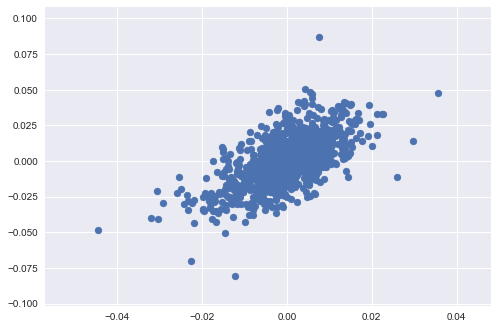

In [12]:
x = ret['kospi'].values
y = ret['se'].values
plt.style.use('seaborn')
plt.scatter(x,y)
plt.show()

$R_{se} = \alpha + \beta R_m + e$

In [13]:
retMonthly = ret.asfreq('m', method='bfill')

monthly_ols = ols('se~1+kospi', data=retMonthly).fit()
monthly_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     se   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                     45.82
Date:                Sat, 04 Dec 2021   Prob (F-statistic):           7.70e-09
Time:                        02:18:43   Log-Likelihood:                 171.73
No. Observations:                  59   AIC:                            -339.5
Df Residuals:                      57   BIC:                            -335.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0012      0.002      0.688      0.494      -0.002       0.005
kospi          1.4112      0.208      6.769      0.000       0.994       1.829
==============================================================================
Omnibus:                        6.984   Durbin-Watson:                   1.659
Prob(Omnibus):                  0.030   Jarque-Bera (JB):                6.599
Skew:                           0.577   Prob(JB):                       0.0369
Kurtosis:                       4.163   Cond. No.                         119.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
coefs_a = []
coefs_b = []
tvalues_a = []
tvalues_b = []

j = 24
while j <= len(retMonthly):
    data = retMonthly.iloc[j-24:j, :]
    coefs = ols('se~1+kospi', data=data).fit().params
    coefs_a.append(coefs[0])
    coefs_b.append(coefs[1])
    tvalues = ols('se~1+kospi', data=data).fit().tvalues
    tvalues_a.append(tvalues[0])
    tvalues_b.append(tvalues[1])
    j += 1

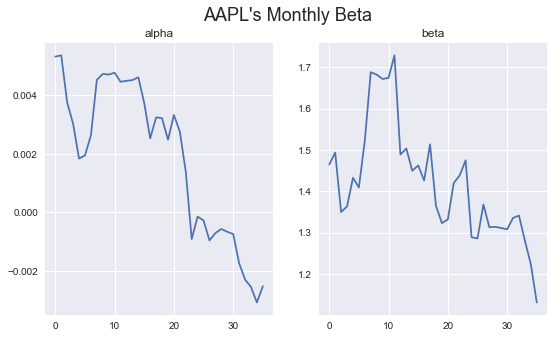

In [16]:
fig, ax = plt.subplots(1,2, figsize=(9,5))

ax[0].plot(coefs_a)
ax[0].set_title("alpha")
ax[1].plot(coefs_b)
ax[1].set_title("beta")
plt.suptitle("AAPL's Monthly Beta", fontsize=18); #AAPL것으로 다시구해보자 이거 이상하다..